# Designing a Recommendation Model

Last updated : November 11th, 2022 

# Introduction

The goal of this project is to develop a draft recommendation model for a mobile application. This model will learn to recommend articles based on the Globocom dataset (https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom), before being applied to the customer dataset.

## 1. Data Processing and Exploration

We will first load and process our dataset.

### 1.1 Loading packages

In [ ]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})
import dill

import os
import shutil

import tensorflow as tf

import sklearn

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate

tf.get_logger().setLevel('ERROR')

### 1.2 Article Metadata

We will now first look at the article metadata.

In [2]:
meta = pd.read_csv('Data/articles_metadata.csv')

meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


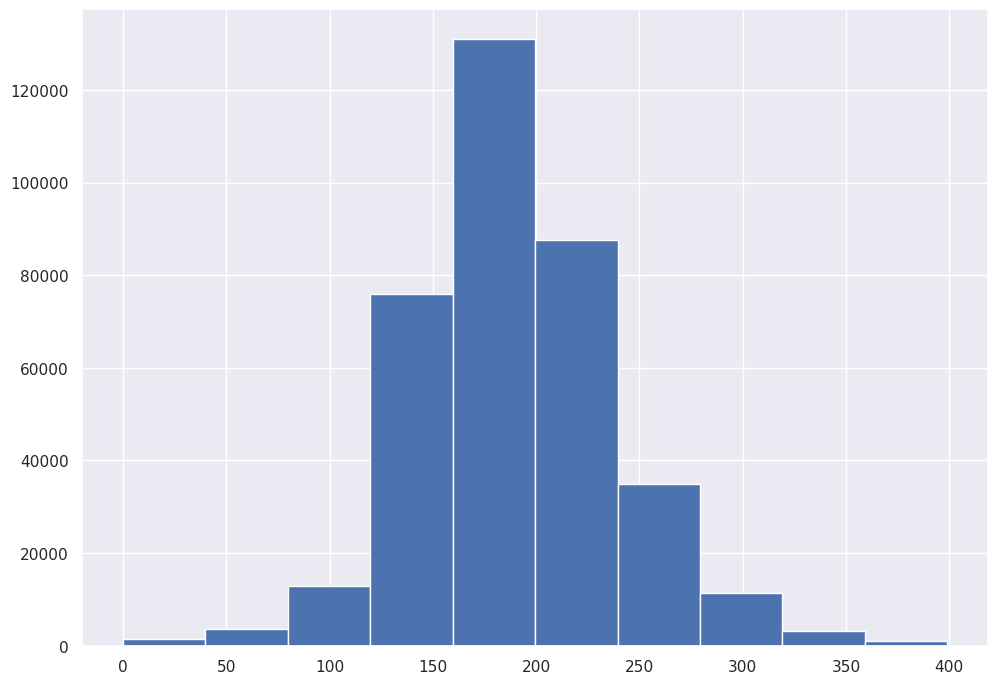

In [3]:
plt.hist(meta[meta.words_count<400].words_count)
plt.show()

We can see that the majority of articles have between 100 and 300 words with almost no articles having over 400 words.

In [4]:
len(meta[meta.words_count>= 400])

1218

In [5]:
print(len(meta.category_id.unique()))

meta.category_id.value_counts(normalize=True)

461


281    0.035207
375    0.027483
399    0.024857
412    0.023755
431    0.021313
         ...   
341    0.000003
121    0.000003
335    0.000003
131    0.000003
0      0.000003
Name: category_id, Length: 461, dtype: float64

There are **vast differences between the representation of different categories** with the top categories included in 3.5% of the articles and **several categories with only one article.** 

In [6]:
#Testing that all article_id are unique
assert len(meta.article_id.unique()) == len(meta)

We will drop the publisher_id column since there is only one value.

In [3]:
len(meta.publisher_id.unique())
# only 1 publisher, we can delete this column

meta.drop(columns={"publisher_id"}, inplace=True)

meta.head()

,article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162


### 1.3 User Click data

We will now load the user click data. First we will look at the provided sample to get familiar with the architecture of this dataframe.

In [8]:
sample = pd.read_csv('Data/clicks_sample.csv')

sample.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


We are now ready to **generate our click dataframe by concatenating all the provided click datafiles** :

In [4]:
CLICK_PATH = 'Data/clicks/'

click_files = [CLICK_PATH + f for f in os.listdir(CLICK_PATH)]

click_files.sort()

print("Number of click files: ", len(click_files))

print("Concatenating click files...")

click_dfs = [pd.read_csv(x) for x in click_files]

click_df = pd.concat(click_dfs, axis=0, ignore_index=True)

print(click_df.shape)
click_df.head()

Number of click files:  385
Concatenating click files...
(2988181, 12)


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In order to **prepare for collaborative filtering**, we will create a dataframe with only the relevant click data : **user_id, article_id and category_id**.

In [10]:
#Collaborative filtering does not require data about users apart from the article they visit
cf_df = click_df.merge(meta, left_on='click_article_id', right_on='article_id', how='inner')

cf_df = cf_df[['user_id', 'article_id', 'category_id']]
print(cf_df.shape)
cf_df.head()

(2988181, 3)


,user_id,article_id,category_id
0,0,157541,281
1,20,157541,281
2,44,157541,281
3,45,157541,281
4,76,157541,281


## 2. Collaborative Filtering (by category)

We are now ready to begin collaborative filtering.

### 2.1 Preprocessing for CF

First of all we need to **create our engagement matrix:**

In [11]:
#Creating user engagement matrix
engagement = cf_df.groupby(['user_id','category_id']).size().reset_index()

engagement.rename(columns={0: 'rating'}, inplace=True)

engagement.head()

,user_id,category_id,rating
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1


In [12]:
print(engagement.rating.describe())

engagement[engagement.rating > 200]

#Some users are particularly active, but the average engagement rating is only 1.6

count    1.882302e+06
mean     1.587514e+00
std      1.921600e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.350000e+02
Name: rating, dtype: float64


,user_id,category_id,rating
132132,11521,398,348
172550,15275,226,211
172551,15275,228,535
179180,15867,375,256
668157,67935,428,303


In [13]:
len(engagement[engagement.rating > 10])
#Only 10 thousand users out of 350k with an engagement of more than 10 on a category

10547

We can see that most users are not very engaged since there are only 10k users with an engagement of over 10 for a single category. 
We choose to keep **engagement in a scale from 1 to 10**:

In [14]:
reader = Reader(rating_scale=(1,10))

X = engagement.loc[engagement.rating > 1]

df = Dataset.load_from_df(X, reader)

print("Number of interactions: ", len(X))

Number of interactions:  503616


Before performing collaborative filtering, we will first **create test-train splits** :

In [15]:
#Creating test and train sets
X_train, X_test = train_test_split(df, test_size=0.1, random_state = 455, shuffle=True)

### 2.2 CF with Surprise module

#### 2.2.1 CF with SVD

We will use Singular Value Decomposition (SVD) as our first algorithm to perform CF.

In [16]:
from surprise import SVD, accuracy

model = SVD()

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)

RMSE: 8.0046
MAE:  7.1258
FCP:  0.0000


**Performing Grid Search to find the best hyperparameters :**

In [18]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5,10,20,30],
             'lr_all': [0.001, 0.002, 0.003, 0.004, 0.005, 0.01],
             'reg_all': [0.2, 0.4, 0.6, 0.8],
              'n_factors': [80,100,120,150,200]
             }

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5, joblib_verbose=10, n_jobs=-1)

gs.fit(df)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

3.153658495759053
{'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.2, 'n_factors': 120}


[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 26.3min finished


In [19]:
model = SVD(n_epochs=30, lr_all=0.002, reg_all=0.2, n_factors=120)

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)


RMSE: 4.1863
MAE:  1.3269
FCP:  0.5143


Second Grid Search with other paramters :

In [20]:
param_grid = {'n_epochs': [30,50,70,100],
             'lr_all': [0.002],
             'reg_all': [0,0.1,0.2],
              'n_factors': [120]
             }

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5, joblib_verbose=10, n_jobs=-1)

gs.fit(df)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:  1.1min remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed:  1.3min remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:  1.5min remaining:    3.1s


3.1397736804051406
{'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.1, 'n_factors': 120}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.5min finished


In [21]:
model = SVD(n_epochs=30, lr_all=0.002, reg_all=0.1, n_factors=120)

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)

RMSE: 4.1770
MAE:  1.3151
FCP:  0.5205


We reach **satisfying results with a RMSE at 4.18, MAE at 1.32 and FCP at 0.52**

Let's now try other algorithms implemented in the Surprise Module.

#### 2.3 CF with SlopeOne

In [23]:
from surprise import SlopeOne

model = SlopeOne()

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)

RMSE: 4.2632
MAE:  1.7197
FCP:  0.5594


The results are slightly below SVD but this is still a very efficient algorithm since there are no hyperparameters to optimize.

We will now try Non-negative Matrix Factorization (NMF) as our algorithm of choice :

#### 2.4 CF with SMF

In [25]:
from surprise import NMF

model = NMF()

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)

RMSE: 4.2666
MAE:  1.6161
FCP:  0.5427


The results without hyperparameter optimization are **very promising, they are only slightly inferior to our optimized SVD model**.

Let's perform Grid Search optimization :

In [27]:
param_grid = {'n_epochs': [20,30,50],
             'reg_pu': [0.02,0.04,0.06,0.08],
              'reg_qi': [0.02,0.04,0.06,0.08],
              'n_factors': [15,30,60,120]
             }

gs = GridSearchCV(NMF, param_grid, measures=["rmse", "fcp"], cv=3, joblib_verbose=10, n_jobs=-1)

gs.fit(df)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

3.213495937940552
{'n_epochs': 30, 'reg_pu': 0.08, 'reg_qi': 0.08, 'n_factors': 120}


[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 24.6min finished


In [28]:
param_grid = {'n_epochs': [30],
             'reg_pu': [0.07,0.08,0.1],
              'reg_qi': [0.07,0.08,0.1],
              'n_factors': [100,120,140,160]
             }

gs = GridSearchCV(NMF, param_grid, measures=["rmse", "fcp"], cv=3, joblib_verbose=10, n_jobs=-1)

gs.fit(df)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])
print(gs.best_score["fcp"])
print(gs.best_params["fcp"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  96 out of 108 | elapsed:  7.8min remaining:   58.6s


3.207734110335018
{'n_epochs': 30, 'reg_pu': 0.08, 'reg_qi': 0.1, 'n_factors': 160}
0.5973364808376528
{'n_epochs': 30, 'reg_pu': 0.1, 'reg_qi': 0.1, 'n_factors': 160}


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  8.6min finished


In [29]:
param_grid = {'n_epochs': [30],
             'reg_pu': [0.1,0.12,0.14,0.17,0.2],
              'reg_qi': [0.1,0.12,0.14,0.17,0.2],
              'n_factors': [160,180,200,250,300]
             }

gs = GridSearchCV(NMF, param_grid, measures=["rmse", "fcp"], cv=3, joblib_verbose=10, n_jobs=-1)

gs.fit(df)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])
print(gs.best_score["fcp"])
print(gs.best_params["fcp"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 2

3.2080978449051347
{'n_epochs': 30, 'reg_pu': 0.1, 'reg_qi': 0.1, 'n_factors': 250}
0.606302193255142
{'n_epochs': 30, 'reg_pu': 0.17, 'reg_qi': 0.2, 'n_factors': 300}


[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 46.5min finished


In [30]:
model = NMF(n_epochs=30, reg_pu = 0.17, reg_qi = 0.2, n_factors=300)

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)

RMSE: 4.2173
MAE:  1.5028
FCP:  0.5531


In [31]:
model = NMF(n_epochs=30, reg_pu = 0.1, reg_qi = 0.1, n_factors=250)

model.fit(X_train)

pred = model.test(X_test)

rmse = accuracy.rmse(pred)
mae = accuracy.mae(pred)
fcp = accuracy.fcp(pred)

RMSE: 4.1977
MAE:  1.5074
FCP:  0.5492


We decide to use **ROOT MEAN SQUARE ERROR (RMSE) as our performance metric** so we use the final model above.

The performance metrics are the best overall with :
    
- **RMSE : 4.20**
- **MAE : 1.51**
- **FCP : 0.55**

Now that we have developped Collaborative Filtering algorithms, we need to use the predictions to actually return the required five articles.

### 2.3 Defining a Category Recommendation algorithm

First we need to get top category predictions for each users:

In [40]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    # First we map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then we sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_5 = get_top_n(pred, n=5)

def findRecom(dic, userId):
    res = []
    query = dic[userId]
    for uid, user_ratings in query:
        res.append(uid)
    return res

categ_recom = findRecom(top_5,5890)

[249, 92, 384, 126, 115]

Now we need to create an algorithm to **recommend articles from the selected categories.**

We need a bit more data processing before defining the algorithm though on the article metadata.  

### 2.4  Defining an Article Recommendation Algorithm

First we need to perform some preprocessing steps on our article data.

Defining an article_id category_id matrix :

In [6]:
articles_categ = meta.loc[:, ['article_id', 'category_id']]

articles_categ

,article_id,category_id
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
364042,364042,460
364043,364043,460
364044,364044,460
364045,364045,460


Now we calculate the **number of clicks per article** :

In [7]:
clicks_per_article = pd.DataFrame(click_df.groupby('click_article_id').size()).reset_index()

clicks_per_article.rename(columns={0: 'article_clicks', 'click_article_id': 'article_id'}, inplace=True)

article_clicks = clicks_per_article.merge(articles_categ, on='article_id', how='left')

article_clicks.set_index('article_id', inplace=True)

article_clicks.sort_values(by='article_clicks', ascending=False, inplace=True)

article_clicks

,article_clicks,category_id
article_id,,
160974,37213,281
272143,28943,399
336221,23851,437
234698,23499,375
123909,23122,250
...,...,...
211316,1,340
92144,1,209
92148,1,209


We merge that data with the article metadata :

In [8]:
article_info = article_clicks.merge(meta[['article_id','created_at_ts']], on='article_id', how='inner')

article_info

,article_id,article_clicks,category_id,created_at_ts
0,160974,37213,281,1506912747000
1,272143,28943,399,1506961870000
2,336221,23851,437,1507613161000
3,234698,23499,375,1507618597000
4,123909,23122,250,1507198955000
...,...,...,...,...
46028,211316,1,340,1476894507000
46029,92144,1,209,1396641786000
46030,92148,1,209,1398260746000
46031,211291,1,340,1475656551000


We **nvert the timestamp to a date**:

In [9]:
import datetime as dt

article_info['date'] = article_info['created_at_ts'].apply(lambda x: dt.datetime.fromtimestamp(x/1000).date())

article_info

,article_id,article_clicks,category_id,created_at_ts,date
0,160974,37213,281,1506912747000,2017-10-02
1,272143,28943,399,1506961870000,2017-10-02
2,336221,23851,437,1507613161000,2017-10-10
3,234698,23499,375,1507618597000,2017-10-10
4,123909,23122,250,1507198955000,2017-10-05
...,...,...,...,...,...
46028,211316,1,340,1476894507000,2016-10-19
46029,92144,1,209,1396641786000,2014-04-04
46030,92148,1,209,1398260746000,2014-04-23
46031,211291,1,340,1475656551000,2016-10-05


Now that we have our full article data, we are **ready to implement our recommendation algorithm**.

It will calculate a **score for each article based on the number of clicks and the publishing date**. 

Then for the **top category**, it will **recommend 3 articles**, and **1 article for the top2 and top 3 categories**.

In [208]:
import random
from dateutil.relativedelta import relativedelta

def calculate_months_diff(x):
    return (today - x).days/30


def recommend_article_from_categ(n:int, categ_id:int, random=True, top_sample=10):
    subset = article_info.loc[article_info.category_id==categ_id].copy()
    
    subset['weighted_score'] = subset['article_clicks']/(subset['date'].apply(calculate_months_diff))
    
    if random:
        #Adding some randomness to the predictions to prevent the same articles being recommended over and over to the same user
        return subset.sort_values(by='weighted_score', ascending=False).head(top_sample).sample(n=n).article_id.to_list()
        
    else:
        return subset.sort_values(by='weighted_score', ascending=False).head(n).article_id.to_list()
    
def recommend_5_articles(user_id: int, recommanded_categories):
    categs = recommanded_categories.copy()
    
    #today = dt.date.today()
    #MUST BE CHANGED IN PRODUCTION, unable to use today because the dataset only goes until 2017
    today = article_info.date.max() #Simulating that today is the last day of our dataset
    
    if len(categs)==0:
        #Recommend top 5 articles of last 6 months
        
        months = today - relativedelta(months=6)
        
        #Returning top 5 articles of last 6 months
        return article_info.loc[article_info.date > months].sort_values(
            by='article_clicks', ascending=False).reset_index().head(5).article_id.to_list()
    
    elif len(categs)==1:
        categ = categs[0]
        
        return recommend_article_from_categ(5, categ_id=categ)
    
    elif len(categs)==2:
        
        categ_1 = categs[0]
        categ_2 = categs[1]
        rec = []
        
        #Generating 3 recommendations for the top category and 2 for the second
        rec.append(recommend_article_from_categ(3, categ_id=categ_1))
        rec.append(recommend_article_from_categ(2, categ_id=categ_2))
        
        #Flattening the recommendations
        rec = list(np.concatenate(rec).flat)
        
        #Shuffling to prevent clustering of the recommendations from the same category
        random.shuffle(rec)
        
        return rec
        
    else:
        
        rec = []
        categ_1 = categs[0]
        categ_2 = categs[1]
        categ_3 = categs[2]
        
        #Generating 3 recommendations for the top category, and 1 for the 2 other top3 categories
        
        rec.append(recommend_article_from_categ(3, categ_id=categ_1))
        rec.append(recommend_article_from_categ(1, categ_id=categ_2))
        rec.append(recommend_article_from_categ(1, categ_id=categ_3))
        
        #Flattening recommendations
        rec = list(np.concatenate(rec).flat)
        
        #Shuffling to prevent clustering of the recommendations from the same category
        random.shuffle(rec)
        
        return rec

In [193]:
recommend_5_articles(5890, categ_recom)

[208150, 207122, 206763, 57616, 202652]

## 3. Content Based - Embedding

### 3.1 Preprocessing Article Embeddings

First we have to load the pickle into a DataFrame :

In [5]:
content = pd.read_pickle('Data/articles_embeddings.pickle')

print(content.shape)

(364047, 250)


In [10]:
embeddings = pd.DataFrame(content)

embeddings.index.names=['article_id']

embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
article_id,,,,,,,,,,,,,,,,,,,,,
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


We are **unable to compute a cosine similarity matrix for all 364k articles because this would require 494GB of RAM.**

We decide to calculate it **only for articles that have already been seen by users** : 

In [233]:
#Keeping only articles which have been seen
seen_articles = click_df.click_article_id.value_counts().index

In [234]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

#Filtering our embeddings and keeping only seen articles
cont = content[seen_articles]

In [246]:
seen_meta =  meta.loc[seen_articles].reset_index()
seen_meta

,index,article_id,category_id,created_at_ts,words_count
0,160974,160974,281,1506912747000,259
1,272143,272143,399,1506961870000,184
2,336221,336221,437,1507613161000,158
3,234698,234698,375,1507618597000,183
4,123909,123909,250,1507198955000,240
...,...,...,...,...,...
46028,3306,3306,1,1505861726000,164
46029,166713,166713,290,1431842611000,197
46030,214721,214721,348,1496820319000,282
46031,350088,350088,442,1451470418000,182


Now we also want to compute a list of which categories are browsed by each user, which will be used to **filter out recommendations** with our limited computing power.

First we create a list of all articles browsed by users :

In [44]:
article_list = click_df.groupby('user_id').agg(
    article_id_list = ('click_article_id', lambda x: list(x)),
)
article_list

,article_id_list
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."
...,...
322892,"[42567, 39894]"
322893,"[50644, 36162]"
322894,"[36162, 168401]"


Then we convert the article_ids into categories :

In [46]:
from tqdm.autonotebook import tqdm

tqdm.pandas()

def find_categories(article_id_list: list):
    categories = []
    for article in article_id_list:
        categories.append(meta[meta.article_id==article].category_id.values[0])
    return categories

article_list['category_list'] = article_list['article_id_list'].progress_apply(find_categories)
    

/tmp/ipykernel_421/2932728648.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/322897 [00:00<?, ?it/s]

Now for each category - user couple we **will calculate the number of clicks and normalize it** :

In [ ]:
category_list = article_list[['category_list']]

categories = category_list.explode('category_list').reset_index()

categories = pd.DataFrame(categories.groupby(['user_id','category_list']).size()).reset_index()

categories.rename(columns={0: 'clicks'}, inplace=True)

categories['clicks_norm'] = categories['clicks'] / categories.groupby('user_id')['clicks'].transform('max')

categories.sort_values(by=['user_id','clicks_norm'], ascending=[True, False], inplace=True)

### 3.2 Cosine Similarities

In this part we will try to computer the cosine similarity of the articles and to use this to predict recommendations for customers.

As mentionned previously, we have already **filtered out unread articles** because we would be unable to compute the full cosine similarity matrix otherwise.

In [235]:
cosine_similarities = cosine_similarity(cont,cont)
cosine_similarities.shape

(46033, 46033)

Now we can define a function that will return the top 20 most similar articles to an article :

In [273]:
def compute_sim_score(article_id):
    sim_scores = list(enumerate(cosine_similarities[article_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #Keep only the top 20 results
    sim_scores = sim_scores[1:21]
    
    return sim_scores
    print(sim_scores)
    
print(compute_sim_score(15323))

[(18, 0.88494503), (34953, 0.87139034), (29883, 0.862418), (26183, 0.85455364), (1665, 0.8530916), (5229, 0.85298204), (36427, 0.8507112), (32547, 0.8506435), (2278, 0.8504091), (25135, 0.8494406), (17952, 0.8430313), (20119, 0.8419783), (30043, 0.84083724), (19514, 0.8387916), (15067, 0.83861864), (2, 0.83695006), (2769, 0.83657575), (6223, 0.83504915), (17707, 0.83462614), (696, 0.8332495)]


In [290]:
user_id = 590

def article_rec(user_id: int):
    subset = categories.loc[categories.user_id == user_id]

    article_similarity_score = []
    for index, row in subset.iterrows():
        #Computing the similarity scores of each articles in the categories browsed by the user
        for article in seen_meta.loc[seen_meta.category_id==int(row.category_list)].index.to_list():
            x = compute_sim_score(int(article))
            article_similarity_score = article_similarity_score + x
    rec = []      
    for row in article_similarity_score:
            index = row[0]
            article_id = seen_meta.loc[index].article_id
            category_id = seen_meta.loc[index].category_id
            #Only calculate click weight if the article is in the list of user browsed categories 
            if category_id in subset.category_list.unique():
                click_weight = subset.loc[subset.category_list == category_id].clicks_norm.values[0] 
                #We use the normalized value of clicked
            else:
                click_weight = 0
            sim_score = row[1]
            rec.append({'index':index, 'article_id':article_id, 'category_id':category_id, 'sim_score':sim_score, 'click_weight':click_weight})

    rec = pd.DataFrame(rec)

    rec = rec.assign(score = lambda x: x['sim_score'] * x['click_weight']) 
    rec.drop_duplicates(subset=['article_id'], inplace=True)

    return rec.sort_values(by='score', ascending=False).head()



,index,article_id,category_id,sim_score,click_weight,score
19180,2180,158998,281,0.985650,1.0,0.985650
17000,4293,159084,281,0.985650,1.0,0.985650
15300,2337,157015,281,0.980383,1.0,0.980383
60660,8918,234536,375,0.943263,1.0,0.943263
51780,14336,235509,375,0.933205,1.0,0.933205


In [286]:
article_similarity_score

[(30073, 0.7759532),
 (24650, 0.7606963),
 (4235, 0.75691366),
 (18914, 0.75094104),
 (37538, 0.7389115),
 (35889, 0.73831373),
 (17874, 0.72926277),
 (31983, 0.72549486),
 (39126, 0.7252109),
 (1351, 0.72070074),
 (6526, 0.7154103),
 (38630, 0.7076823),
 (16889, 0.7073035),
 (32261, 0.70521384),
 (14098, 0.7045937),
 (25546, 0.7024979),
 (21032, 0.702174),
 (20781, 0.6992214),
 (3394, 0.69916505),
 (13966, 0.69779074),
 (30073, 0.7759532),
 (24650, 0.7606963),
 (4235, 0.75691366),
 (18914, 0.75094104),
 (37538, 0.7389115),
 (35889, 0.73831373),
 (17874, 0.72926277),
 (31983, 0.72549486),
 (39126, 0.7252109),
 (1351, 0.72070074),
 (6526, 0.7154103),
 (38630, 0.7076823),
 (16889, 0.7073035),
 (32261, 0.70521384),
 (14098, 0.7045937),
 (25546, 0.7024979),
 (21032, 0.702174),
 (20781, 0.6992214),
 (3394, 0.69916505),
 (13966, 0.69779074),
 (13431, 0.796504),
 (2033, 0.79421437),
 (17097, 0.7785375),
 (30073, 0.7686279),
 (31826, 0.76499146),
 (16889, 0.75756586),
 (3104, 0.7534797),
 (302

In [280]:
user_id = 590
subset = categories.loc[categories.user_id == user_id]

article_similarity_score = []
for index, row in subset.iterrows():
    for article in seen_meta.loc[seen_meta.category_id==int(row.category_list)].index.to_list():
        x = compute_sim_score(int(row.category_list))
        for i in range(1, int(row.clicks) + 1):
            article_similarity_score = article_similarity_score + x
rec = []      
for row in article_similarity_score:
        index = row[0]
        article_id = seen_meta.loc[index].article_id
        category_id = seen_meta.loc[index].category_id
        if category_id in subset.category_list.unique():
            click_weight = subset.loc[subset.category_list == category_id].clicks_norm.values[0] #We use normalized value of clicked, we could use non normalized too.
        else:
            click_weight = 0
        sim_score = row[1]
        rec.append({'index':index, 'article_id':article_id, 'category_id':category_id, 'sim_score':sim_score, 'click_weight':click_weight})

rec = pd.DataFrame(rec)

rec = rec.assign(score = lambda x: x['sim_score'] * x['click_weight']) 
rec.drop_duplicates(subset=['article_id'], inplace=True)

rec.sort_values(by='score', ascending=False).head(5)

KeyboardInterrupt: 

In [274]:
rec.drop_duplicates(subset=['article_id'], inplace=True)

rec.sort_values(by='score', ascending=False).head(5)

,index,article_id,category_id,sim_score,click_weight,score
101480,989,159266,281,0.928678,1.0,0.928678
101481,35444,157791,281,0.903506,1.0,0.903506
192220,593,162718,281,0.884245,1.0,0.884245
101482,4943,157792,281,0.879511,1.0,0.879511
101483,3597,159450,281,0.878364,1.0,0.878364


In [308]:
import umap.umap_ as umap
mapping = umap.UMAP(n_components=2, verbose=10).fit(embeddings)

UMAP( verbose=10)
Tue Nov  8 11:03:58 2022 Construct fuzzy simplicial set
Tue Nov  8 11:03:58 2022 Finding Nearest Neighbors
Tue Nov  8 11:03:58 2022 Building RP forest with 35 trees
Tue Nov  8 11:04:04 2022 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	Stopping threshold met -- exiting after 4 iterations
Tue Nov  8 11:04:20 2022 Finished Nearest Neighbor Search
Tue Nov  8 11:04:22 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Nov  8 11:07:02 2022 Finished embedding


<AxesSubplot:>

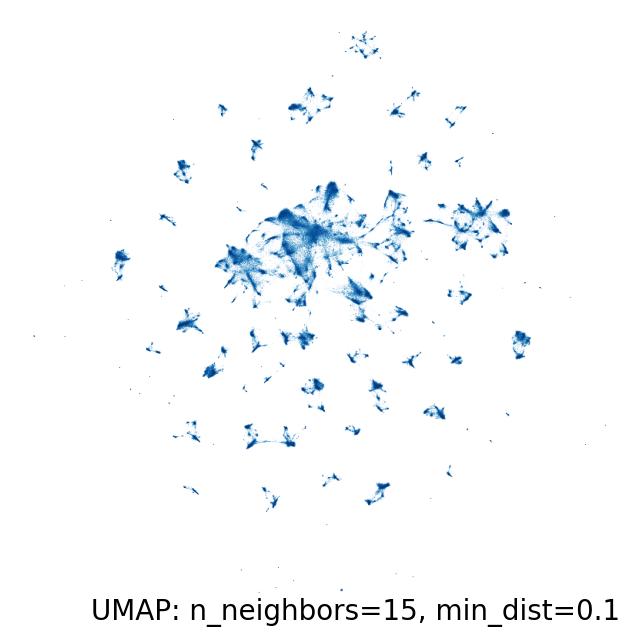

In [309]:
import umap.plot
umap.plot.points(mapping)
plt.title("Visualisation of Article Embeddings reduced to 2D with UMAP")
plt.show()

In [313]:
import umap.umap_ as umap
X_reduced = umap.UMAP(n_components=5, verbose=10).fit_transform(embeddings)

X_reduced

UMAP(n_components=5, verbose=10)
Tue Nov  8 11:08:40 2022 Construct fuzzy simplicial set
Tue Nov  8 11:08:41 2022 Finding Nearest Neighbors
Tue Nov  8 11:08:41 2022 Building RP forest with 35 trees
Tue Nov  8 11:08:46 2022 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	Stopping threshold met -- exiting after 4 iterations
Tue Nov  8 11:09:02 2022 Finished Nearest Neighbor Search
Tue Nov  8 11:09:03 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Nov  8 11:12:43 2022 Finished embedding


array([[14.758886 , -3.2056735,  2.7360387, 10.165521 , 14.44509  ],
       [ 7.997519 ,  2.9346814,  1.2820976,  9.214203 ,  9.977556 ],
       [ 7.8419538, 11.035439 ,  0.7422627, 10.121692 , 11.456087 ],
       ...,
       [ 7.183344 ,  4.066413 ,  2.9234211, 10.094478 , 11.043172 ],
       [ 9.699909 ,  2.4688792,  3.81887  , 12.021471 , 10.231158 ],
       [ 6.8551955, -1.4955616, -5.119304 ,  9.594808 , 12.976814 ]],
      dtype=float32)

## 3. Deep Learning Route

In [11]:
article_features = embeddings.merge(article_info.drop(columns={'created_at_ts','date'}).set_index("article_id"),
                                    right_index=True, left_index=True)

article_features

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,article_clicks,category_id
article_id,,,,,,,,,,,,,,,,,,,,,
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329,1,1
27,-0.700814,-0.965927,-0.181869,-0.423504,-0.024668,0.187061,-0.674657,-0.108778,-0.762116,0.161282,...,0.495848,-0.629343,-0.231966,0.564555,-0.762103,-0.388876,0.696865,-0.532873,1,1
69,0.093521,-0.981410,0.848944,0.530125,0.767768,0.067014,-0.764069,-0.238016,-0.504944,-0.215097,...,-0.361129,-0.228905,-0.815412,-0.150129,-0.309511,-0.877652,0.643542,-0.908095,1,1
81,0.221564,-0.978803,0.614596,-0.049789,0.159638,-0.029031,-0.716393,-0.287863,-0.622962,-0.040135,...,0.073361,-0.152517,-0.645792,0.680978,-0.519698,-0.248209,0.717366,-0.816945,2,1
84,-0.497972,-0.976125,0.812216,-0.591446,0.876975,0.338400,-0.701809,-0.711910,-0.168073,-0.162825,...,-0.393486,-0.001957,-0.736190,-0.202507,0.102859,-0.833087,0.780866,-0.817214,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364017,0.290270,-0.963398,-0.019136,0.596347,-0.589016,-0.091982,0.223495,-0.072997,0.472463,0.119069,...,0.005308,-0.169417,0.443876,0.299790,0.257217,0.615377,0.048421,-0.309620,22,458
364022,0.529817,-0.967979,0.503438,0.448184,0.181285,-0.245775,0.094118,0.253014,-0.301180,0.295364,...,-0.332256,-0.330351,-0.270494,0.700624,-0.471617,-0.323244,-0.237431,-0.838007,1,460
364028,0.490527,-0.977612,0.843583,0.706493,0.136944,0.249855,-0.593310,-0.655806,-0.293649,-0.561186,...,-0.668198,-0.529896,-0.402550,0.416018,0.117111,-0.154201,0.061264,-0.805267,1,460


In [12]:
#Keeping only articles with more than 100 clicks
top_articles = article_info.loc[article_info.article_clicks > 200][['article_id']].article_id.to_list()

len(top_articles)

1578

In [13]:
article_features = article_features[article_features.index.isin(top_articles)]

article_features

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,article_clicks,category_id
article_id,,,,,,,,,,,,,,,,,,,,,
2647,-0.578509,-0.961938,0.100678,-0.273575,-0.349844,0.118716,-0.336729,0.229771,-0.340441,0.231246,...,0.552505,-0.299282,-0.607514,0.148763,-0.633291,-0.384769,0.219881,-0.624112,594,1
3394,-0.787703,-0.975713,-0.505141,-0.804134,-0.407822,-0.018479,-0.369428,0.337588,-0.509037,-0.167686,...,0.373346,-0.664766,-0.622600,0.466372,-0.887352,-0.475702,0.733142,-0.653628,300,1
4789,-0.493438,-0.950074,-0.702956,-0.716612,-0.153035,0.146199,-0.291075,0.489244,-0.211987,-0.321202,...,0.070819,-0.548221,-0.010081,0.012795,-0.773824,-0.277625,-0.038640,-0.156194,267,2
4907,-0.494561,-0.973119,-0.440484,-0.397784,-0.158182,-0.327624,-0.703008,0.781154,-0.594276,-0.565696,...,0.358992,-0.909490,-0.685848,-0.111571,-0.895428,-0.750964,0.581844,-0.477662,603,2
5252,-0.572674,-0.960608,-0.683330,-0.571849,-0.618968,-0.579806,-0.488288,0.499275,-0.347327,-0.509361,...,0.471174,-0.408515,-0.539252,-0.261824,-0.698086,-0.494651,0.902350,-0.330455,512,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362322,0.335478,-0.959239,-0.951306,-0.406064,-0.330629,0.037013,0.000713,0.495789,-0.847175,0.014472,...,-0.525694,-0.037099,0.890719,-0.292839,0.575249,-0.663193,-0.457781,0.238902,373,455
362914,-0.780239,-0.975677,-0.771250,-0.446969,-0.347134,0.646576,-0.777463,0.717298,-0.695587,-0.033085,...,-0.066965,-0.511438,0.439294,-0.093052,0.243503,-0.400268,-0.376211,0.286065,992,455
363173,-0.601511,-0.955274,-0.883544,-0.709053,-0.343706,-0.158635,-0.375694,0.606922,-0.455301,0.060392,...,-0.036938,0.068263,0.808108,0.253096,0.147109,-0.352388,0.474136,0.540502,320,455


In [14]:
article_corr = article_features.reset_index()[['article_id']]

article_corr

,article_id
0,2647
1,3394
2,4789
3,4907
4,5252
...,...
1573,362322
1574,362914
1575,363173
1576,363910


In [15]:
article_features = article_features.reset_index().drop(columns={'article_id'})

article_features

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,article_clicks,category_id
0,-0.578509,-0.961938,0.100678,-0.273575,-0.349844,0.118716,-0.336729,0.229771,-0.340441,0.231246,...,0.552505,-0.299282,-0.607514,0.148763,-0.633291,-0.384769,0.219881,-0.624112,594,1
1,-0.787703,-0.975713,-0.505141,-0.804134,-0.407822,-0.018479,-0.369428,0.337588,-0.509037,-0.167686,...,0.373346,-0.664766,-0.622600,0.466372,-0.887352,-0.475702,0.733142,-0.653628,300,1
2,-0.493438,-0.950074,-0.702956,-0.716612,-0.153035,0.146199,-0.291075,0.489244,-0.211987,-0.321202,...,0.070819,-0.548221,-0.010081,0.012795,-0.773824,-0.277625,-0.038640,-0.156194,267,2
3,-0.494561,-0.973119,-0.440484,-0.397784,-0.158182,-0.327624,-0.703008,0.781154,-0.594276,-0.565696,...,0.358992,-0.909490,-0.685848,-0.111571,-0.895428,-0.750964,0.581844,-0.477662,603,2
4,-0.572674,-0.960608,-0.683330,-0.571849,-0.618968,-0.579806,-0.488288,0.499275,-0.347327,-0.509361,...,0.471174,-0.408515,-0.539252,-0.261824,-0.698086,-0.494651,0.902350,-0.330455,512,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,0.335478,-0.959239,-0.951306,-0.406064,-0.330629,0.037013,0.000713,0.495789,-0.847175,0.014472,...,-0.525694,-0.037099,0.890719,-0.292839,0.575249,-0.663193,-0.457781,0.238902,373,455
1574,-0.780239,-0.975677,-0.771250,-0.446969,-0.347134,0.646576,-0.777463,0.717298,-0.695587,-0.033085,...,-0.066965,-0.511438,0.439294,-0.093052,0.243503,-0.400268,-0.376211,0.286065,992,455
1575,-0.601511,-0.955274,-0.883544,-0.709053,-0.343706,-0.158635,-0.375694,0.606922,-0.455301,0.060392,...,-0.036938,0.068263,0.808108,0.253096,0.147109,-0.352388,0.474136,0.540502,320,455
1576,0.236520,-0.971633,0.118691,0.537056,-0.554408,0.248209,-0.383083,0.675659,0.051024,0.145055,...,-0.107619,-0.598164,-0.013409,0.327100,0.508268,0.478775,-0.053646,0.528788,301,458


In [16]:
from sklearn.preprocessing import StandardScaler
articles_scaled = StandardScaler().fit_transform(article_features)

articles_scaled

/home/faskill/miniconda3/envs/pro7/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/faskill/miniconda3/envs/pro7/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([[-0.59628592,  0.12054441,  0.45048376, ..., -2.13138862,
        -0.34088496, -2.5322095 ],
       [-1.10457942, -0.61788935, -0.92578429, ..., -2.21353811,
        -0.43868783, -2.5322095 ],
       [-0.38958043,  0.75649701, -1.3751713 , ..., -0.82905986,
        -0.44966571, -2.52361705],
       ...,
       [-0.65217547,  0.47776511, -1.78542125, ...,  1.1100097 ,
        -0.43203458,  1.36876498],
       [ 1.38405446, -0.39916872,  0.49140629, ...,  1.07740624,
        -0.43835517,  1.39454235],
       [ 1.29029539,  0.59056661,  0.96412822, ...,  0.79711517,
        -0.39278036,  1.39454235]])

In [18]:
with open('Data/articles_scaled.pkl','wb') as file:
    dill.dump(articles_scaled, file)

In [2]:
with open('Data/articles_scaled.pkl','rb') as file:
    articles_scaled = dill.load(file)

In [3]:
import umap.umap_ as umap
articles_reduced = umap.UMAP(n_components=10, verbose=10).fit_transform(articles_scaled)

articles_reduced

UMAP(n_components=10, verbose=10)
Thu Nov 10 11:58:51 2022 Construct fuzzy simplicial set
Thu Nov 10 11:58:52 2022 Finding Nearest Neighbors
Thu Nov 10 11:58:54 2022 Finished Nearest Neighbor Search
Thu Nov 10 11:58:55 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Nov 10 11:58:57 2022 Finished embedding


array([[ 3.217053 ,  9.071956 ,  5.4197965, ...,  7.2840624,  6.698864 ,
         9.000759 ],
       [ 3.1553102,  9.094804 ,  5.4399056, ...,  7.210621 ,  6.704695 ,
         8.931273 ],
       [ 3.2046547,  9.115732 ,  5.5008206, ...,  7.1868486,  6.739362 ,
         8.940784 ],
       ...,
       [ 3.2331166,  9.305272 ,  5.5361485, ...,  7.15547  ,  7.092298 ,
         8.823031 ],
       [ 3.422479 ,  9.522741 ,  5.9050922, ...,  8.011358 ,  7.1851497,
        10.602387 ],
       [ 3.4705522,  9.393051 ,  5.8026457, ...,  7.870005 ,  7.3332925,
        10.384352 ]], dtype=float32)

In [4]:
articles_reduced = pd.DataFrame(articles_reduced)

articles_reduced.iloc[0].to_list()

[3.217052936553955,
 9.071955680847168,
 5.419796466827393,
 0.8309723138809204,
 6.956783771514893,
 6.162824630737305,
 1.1813942193984985,
 7.284062385559082,
 6.698863983154297,
 9.00075912475586]

In [12]:
# import category_encoders as ce

# X_articles = ce.one_hot.OneHotEncoder(cols=['category_id'], use_cat_names=True).fit_transform(article_features)

# print(X_articles.shape)
# X_articles

(46033, 567)


,0,1,2,3,4,5,6,7,8,9,...,category_id_448.0,category_id_449.0,category_id_450.0,category_id_451.0,category_id_453.0,category_id_454.0,category_id_455.0,category_id_456.0,category_id_458.0,category_id_460.0
article_id,,,,,,,,,,,,,,,,,,,,,
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0,0,0,0,0,0,0,0,0,0
27,-0.700814,-0.965927,-0.181869,-0.423504,-0.024668,0.187061,-0.674657,-0.108778,-0.762116,0.161282,...,0,0,0,0,0,0,0,0,0,0
69,0.093521,-0.981410,0.848944,0.530125,0.767768,0.067014,-0.764069,-0.238016,-0.504944,-0.215097,...,0,0,0,0,0,0,0,0,0,0
81,0.221564,-0.978803,0.614596,-0.049789,0.159638,-0.029031,-0.716393,-0.287863,-0.622962,-0.040135,...,0,0,0,0,0,0,0,0,0,0
84,-0.497972,-0.976125,0.812216,-0.591446,0.876975,0.338400,-0.701809,-0.711910,-0.168073,-0.162825,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364017,0.290270,-0.963398,-0.019136,0.596347,-0.589016,-0.091982,0.223495,-0.072997,0.472463,0.119069,...,0,0,0,0,0,0,0,0,1,0
364022,0.529817,-0.967979,0.503438,0.448184,0.181285,-0.245775,0.094118,0.253014,-0.301180,0.295364,...,0,0,0,0,0,0,0,0,0,1
364028,0.490527,-0.977612,0.843583,0.706493,0.136944,0.249855,-0.593310,-0.655806,-0.293649,-0.561186,...,0,0,0,0,0,0,0,0,0,1


In [18]:
# users = click_df.groupby(['user_id', 'click_article_id']).progress_aggregate(clicks = ('click_timestamp', 'nunique'),
#                                                              click_environment = ('click_environment',
#                                                                                   lambda x: pd.Series.mode(x)[0]),
#                                                              click_device_group = ('click_deviceGroup',
#                                                                                   lambda x: pd.Series.mode(x)[0]),
#                                                              click_os=('click_os', 
#                                                                       lambda x: pd.Series.mode(x)[0]),
#                                                              click_country = ('click_country',
#                                                                              lambda x: pd.Series.mode(x)[0]),
#                                                               click_region = ('click_region',
#                                                                              lambda x: pd.Series.mode(x)[0]),
#                                                               click_referrer_type = ('click_referrer_type',
#                                                                                     lambda x: pd.Series.mode(x)[0]),
#                                                               last_click = ('click_timestamp', 'max'),
                                                              
#                                                               first_click = ('click_timestamp', 'min'),
                                                              
#                                                               session_size = ('session_size', 'mean')
#                                                              )

users = click_df.groupby(['user_id','click_article_id']).agg(clicks=('click_timestamp', 'nunique'))

users.head()

clicks
user_id click_article_id        
0       68866                  1
        87205                  1
        87224                  1
        96755                  1
        157541                 1

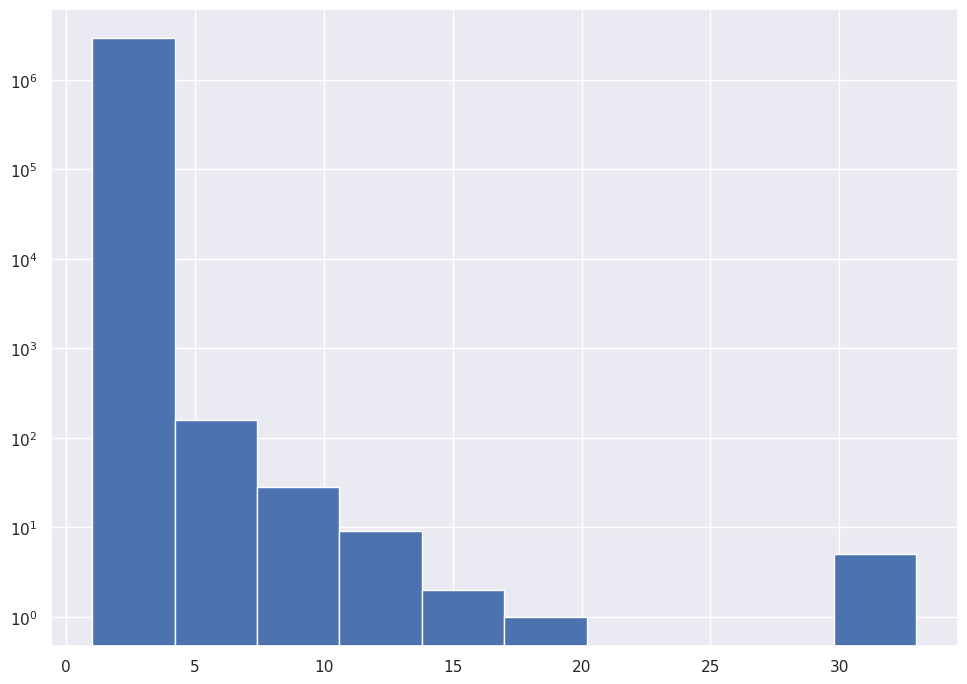

In [331]:
plt.hist(users.clicks)
plt.yscale('log')
plt.show()

In [332]:
users.shape

(2950710, 1)

In [19]:
users.loc[users.clicks > 1, 'clicks'] = 2
users.reset_index(inplace=True)
users.rename(columns={'click_article_id': 'article_id'}, inplace=True)
users

,user_id,article_id,clicks
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1
...,...,...,...
2950705,322894,168401,1
2950706,322895,63746,1
2950707,322895,289197,1
2950708,322896,30760,1


In [20]:
users.rename(columns={'clicks': 'y'}, inplace=True)
users.loc[users.y > 1, 'y'] = 2
users

,user_id,article_id,y
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1
...,...,...,...
2950705,322894,168401,1
2950706,322895,63746,1
2950707,322895,289197,1
2950708,322896,30760,1


In [21]:
user_df = users.loc[users.article_id.isin(top_articles)]

len(user_df.article_id.unique())


1578

In [22]:
from tqdm.notebook import tqdm
tqdm.pandas()
def transform_article_ids(x):
    return article_corr.loc[article_corr.article_id==int(x)].index[0]

user_df['article_id'] = user_df['article_id'].progress_apply(transform_article_ids)

users

  0%|          | 0/2523767 [00:00<?, ?it/s]

/tmp/ipykernel_181/3819557803.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df['article_id'] = user_df['article_id'].progress_apply(transform_article_ids)


,user_id,article_id,y
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1
...,...,...,...
2950705,322894,168401,1
2950706,322895,63746,1
2950707,322895,289197,1
2950708,322896,30760,1


In [23]:
dtf_users = user_df.pivot_table(index="user_id", columns="article_id", values="y")

dtf_users.fillna(0, inplace=True)

dtf_users

article_id,0,1,2,3,4,5,6,7,8,9,...,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
322892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
322893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
import dill
with open('Data/dtf_users_trimmed.pkl','wb') as file:
    dill.dump(dtf_users, file)

In [2]:
import dill
with open('Data/dtf_users_trimmed.pkl','rb') as file:
    dtf_users = pd.DataFrame(dill.load(file))

In [3]:
from sklearn.model_selection import train_test_split
train_users, test_users = train_test_split(dtf_users, test_size=0.1, random_state = 455, shuffle=True)
train_users, val_users = train_test_split(train_users, test_size=0.1/0.9, random_state = 455, shuffle=True)

In [4]:
train_df = train_users.stack().reset_index().rename(columns={0:'y'})
test_df = test_users.stack().reset_index().rename(columns={0:'y'})
val_df = val_users.stack().reset_index().rename(columns={0:'y'})

train_df.head()

,user_id,article_id,y
0,102700,0,0.0
1,102700,1,0.0
2,102700,2,0.0
3,102700,3,0.0
4,102700,4,0.0


In [5]:
with open('Data/train_df_trimmed.pkl','wb') as file:
    dill.dump(train_df, file)
with open('Data/test_df_trimmed.pkl','wb') as file:
    dill.dump(test_df, file)
with open('Data/val_df_trimmed.pkl','wb') as file:
    dill.dump(val_df, file)

In [5]:
with open('Data/train_df_trimmed.pkl','rb') as file:
    train_df = dill.load(file)
with open('Data/test_df_trimmed.pkl','rb') as file:
    test_df = dill.load(file)
with open('Data/val_df_trimmed.pkl','rb') as file:
    val_df = dill.load(file)

In [6]:
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_df[['user_id','article_id']]),train_df['y'])).batch(100000).cache()
test_ds = tf.data.Dataset.from_tensor_slices((dict(test_df[['user_id','article_id']]),test_df['y'])).batch(100000).cache()
val_ds = tf.data.Dataset.from_tensor_slices((dict(val_df[['user_id','article_id']]),val_df['y'])).batch(100000).cache()

2022-11-10 10:54:25.429862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-10 10:54:25.444418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-10 10:54:25.444435: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-10 10:54:25.445012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [8]:
import pprint
for x in train_ds.take(5).as_numpy_iterator():
  pprint.pprint(x)

2022-11-10 10:54:27.995553: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3157199280 exceeds 10% of free system memory.
2022-11-10 10:54:28.871185: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3157199280 exceeds 10% of free system memory.
2022-11-10 10:54:30.010229: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3157199280 exceeds 10% of free system memory.


({'article_id': array([  0,   1,   2, ..., 583, 584, 585]),
  'user_id': array([102700, 102700, 102700, ..., 193484, 193484, 193484])},
 array([0., 0., 0., ..., 0., 0., 0.]))
({'article_id': array([ 586,  587,  588, ..., 1169, 1170, 1171]),
  'user_id': array([193484, 193484, 193484, ...,  25957,  25957,  25957])},
 array([0., 0., 0., ..., 0., 0., 0.]))
({'article_id': array([1172, 1173, 1174, ...,  177,  178,  179]),
  'user_id': array([ 25957,  25957,  25957, ..., 137911, 137911, 137911])},
 array([0., 0., 0., ..., 0., 0., 0.]))
({'article_id': array([180, 181, 182, ..., 763, 764, 765]),
  'user_id': array([137911, 137911, 137911, ...,  87093,  87093,  87093])},
 array([0., 0., 0., ..., 0., 0., 0.]))
({'article_id': array([ 766,  767,  768, ..., 1349, 1350, 1351]),
  'user_id': array([87093, 87093, 87093, ..., 43442, 43442, 43442])},
 array([0., 0., 0., ..., 0., 0., 0.]))


2022-11-10 10:54:32.103251: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


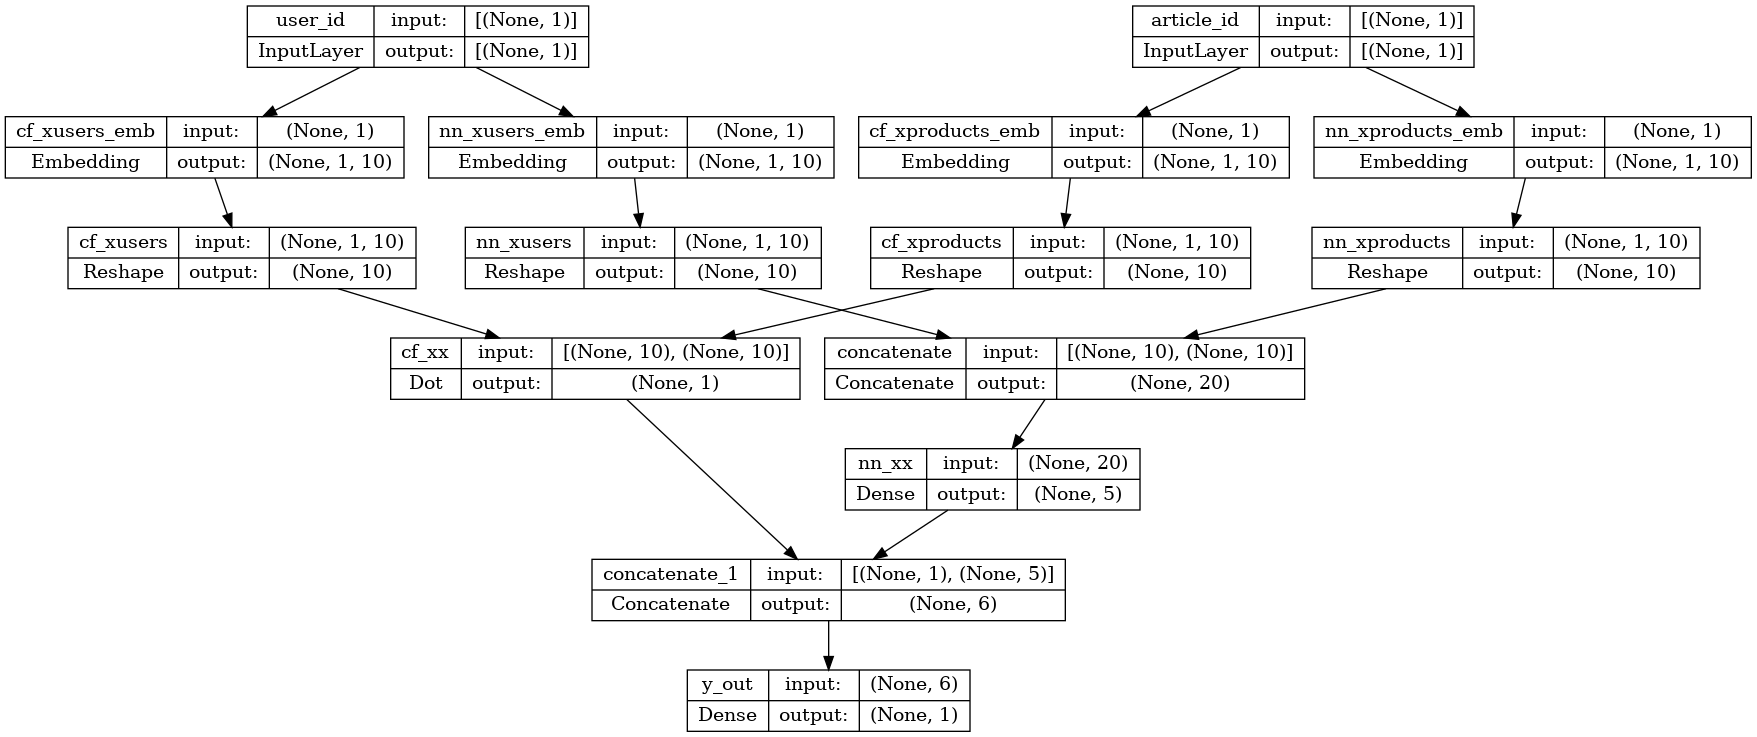

In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

embeddings_size = 10
usr, prd = 322897, 1578
# Input layer
xusers_in = layers.Input(name="user_id", shape=(1,))
xproducts_in = layers.Input(name="article_id", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)
# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
plot_model(model, show_shapes=True, show_layer_names=True)

In [10]:
model.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 article_id (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 10)        3228970     ['user_id[0][0]']                
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 10)        15780       ['article_id[0][0]']             
                                                                      

In [12]:
# Train
history = model.fit(train_ds, epochs=10, shuffle=True, verbose=True, validation_data=val_ds)
model.evaluate(test_ds)

Epoch 1/10
3947/3947 [==============================] - 1191s 302ms/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0724
Epoch 2/10
3947/3947 [==============================] - 182s 46ms/step - loss: 0.0051 - root_mean_squared_error: 0.0716 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0724
Epoch 3/10
3947/3947 [==============================] - 182s 46ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 4/10
3947/3947 [==============================] - 186s 47ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 5/10
2345/3947 [================>.............] - ETA: 1:11 - loss: 0.0049 - root_mean_squared_error: 0.0703

KeyboardInterrupt: 

In [13]:
test_df["yhat"] = model.predict(test_ds)

test_df

494/494 [==============================] - 120s 243ms/step


,user_id,article_id,y,yhat
0,296832,0,0.0,0.002809
1,296832,1,0.0,-0.002355
2,296832,2,0.0,-0.001920
3,296832,3,0.0,-0.002466
4,296832,4,0.0,-0.004259
...,...,...,...,...
49331431,95815,1573,0.0,-0.001584
49331432,95815,1574,0.0,-0.001440
49331433,95815,1575,0.0,-0.001261
49331434,95815,1576,0.0,0.008038


In [17]:
model.evaluate(test_ds)



494/494 [==============================] - 4s 7ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724


[0.005237926263362169, 0.07237351685762405]

In [16]:
test_df.sort_values(by='yhat', ascending=False).loc[test_df.y > 0]

,user_id,article_id,y,yhat
40829793,60146,621,1.0,0.436515
47121279,48342,621,1.0,0.428807
49218441,64814,621,1.0,0.422843
11433231,55529,621,1.0,0.417485
26195421,79247,621,1.0,0.412996
...,...,...,...,...
32057747,68980,677,1.0,-0.011715
2523843,54874,621,1.0,-0.012229
2183051,13748,677,1.0,-0.012765
11993477,61535,677,1.0,-0.013791


In [7]:
#Using only first 10k users for hybrid model to enable loading of dataset in memory
train_df_reduced = train_df.loc[train_df.user_id < 10000]
test_df_reduced = test_df.loc[test_df.user_id < 10000]
val_df_reduced = val_df.loc[val_df.user_id < 10000]

print(train_df_reduced.shape, test_df_reduced.shape, val_df_reduced.shape)

(12371520, 3) (1532238, 3) (1607982, 3)


In [19]:
articles_reduced = articles_reduced.reset_index()

articles_reduced.columns=["article_id","feat_1","feat_2","feat_3","feat_4","feat_5",
                         "feat_6","feat_7","feat_8","feat_9","feat_10"]

articles_reduced

,article_id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10
0,0,3.217053,9.071956,5.419796,0.830972,6.956784,6.162825,1.181394,7.284062,6.698864,9.000759
1,1,3.155310,9.094804,5.439906,0.887519,6.988012,6.182938,1.302051,7.210621,6.704695,8.931273
2,2,3.204655,9.115732,5.500821,0.897319,6.960971,6.200922,1.264889,7.186849,6.739362,8.940784
3,3,3.159485,9.095418,5.448451,0.887508,6.974744,6.191198,1.291049,7.199757,6.707733,8.931231
4,4,3.158179,9.097180,5.436575,0.881656,6.983354,6.162414,1.286717,7.209692,6.719574,8.931170
...,...,...,...,...,...,...,...,...,...,...,...
1573,1573,3.262861,9.361030,5.518291,0.812211,7.087306,5.721117,1.334636,7.174518,7.147093,8.852273
1574,1574,3.225296,9.297792,5.553564,0.843832,7.109157,5.792815,1.361006,7.139386,7.082516,8.815535
1575,1575,3.233117,9.305272,5.536149,0.833570,7.097963,5.766860,1.356501,7.155470,7.092298,8.823031
1576,1576,3.422479,9.522741,5.905092,0.721111,6.330519,5.840443,-0.235284,8.011358,7.185150,10.602387


In [15]:
train_df_reduced

,user_id,article_id,y
17358,2831,0,0.0
17359,2831,1,0.0
17360,2831,2,0.0
17361,2831,3,0.0
17362,2831,4,0.0
...,...,...,...
394632547,3399,1573,0.0
394632548,3399,1574,0.0
394632549,3399,1575,0.0
394632550,3399,1576,0.0


In [20]:
train_df_reduced = train_df_reduced.merge(articles_reduced, on="article_id", how='left')
test_df_reduced = test_df_reduced.merge(articles_reduced, on="article_id", how='left')
val_df_reduced = val_df_reduced.merge(articles_reduced, on="article_id", how='left')

val_df_reduced.head()

,user_id,article_id,y,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10
0,8037,0,0.0,3.217053,9.071956,5.419796,0.830972,6.956784,6.162825,1.181394,7.284062,6.698864,9.000759
1,8037,1,0.0,3.155310,9.094804,5.439906,0.887519,6.988012,6.182938,1.302051,7.210621,6.704695,8.931273
2,8037,2,0.0,3.204655,9.115732,5.500821,0.897319,6.960971,6.200922,1.264889,7.186849,6.739362,8.940784
3,8037,3,0.0,3.159485,9.095418,5.448451,0.887508,6.974744,6.191198,1.291049,7.199757,6.707733,8.931231
4,8037,4,0.0,3.158179,9.097180,5.436575,0.881656,6.983354,6.162414,1.286717,7.209692,6.719574,8.931170


In [21]:
with open('Data/train_df_red.pkl','wb') as file:
    dill.dump(train_df_reduced, file)
with open('Data/test_df_red.pkl','wb') as file:
    dill.dump(test_df_reduced, file)
with open('Data/val_df_red.pkl','wb') as file:
    dill.dump(val_df_reduced, file)

In [22]:
train_ds_red = tf.data.Dataset.from_tensor_slices((dict(train_df_reduced.drop(columns='y')),
                                               train_df_reduced['y'])).batch(20).cache()
test_ds_red = tf.data.Dataset.from_tensor_slices((dict(test_df_reduced.drop(columns='y')),
                                               test_df_reduced['y'])).batch(20).cache()
val_ds_red = tf.data.Dataset.from_tensor_slices((dict(val_df_reduced.drop(columns='y')),
                                               val_df_reduced['y'])).batch(20).cache()

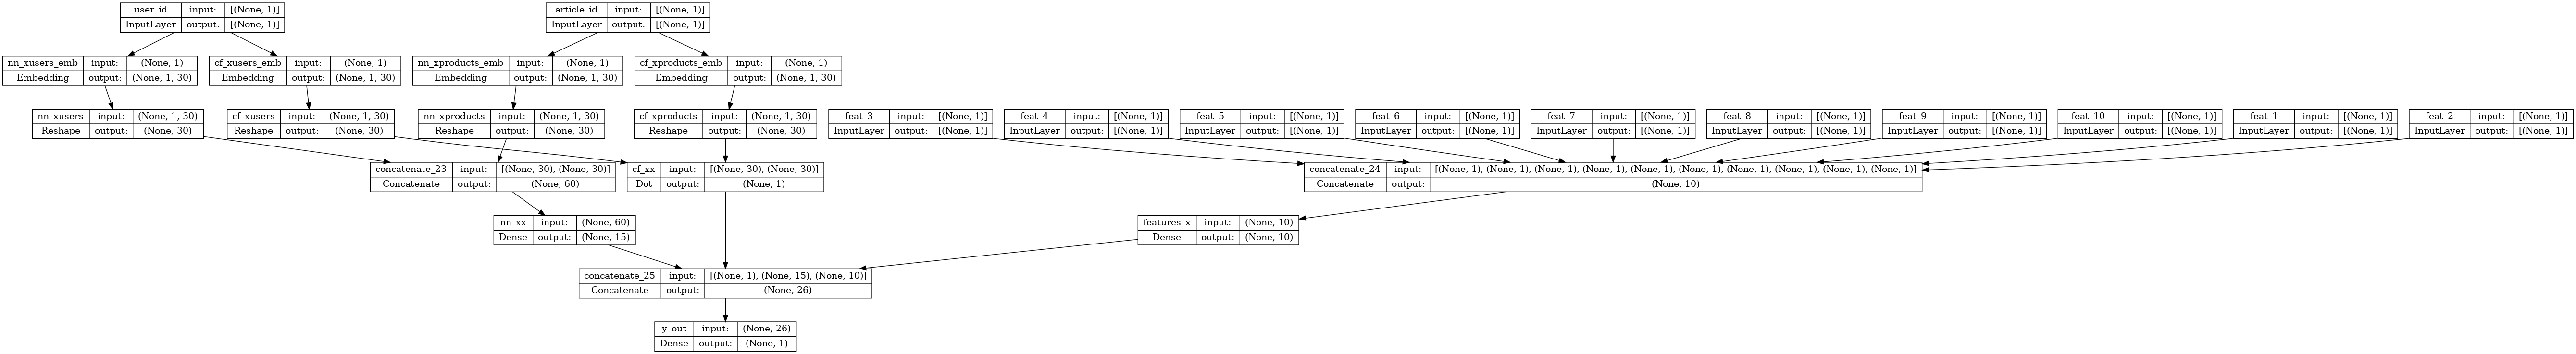

In [39]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

embeddings_size = 30
usr, prd = 50000, 1578
feat = 10
################### COLLABORATIVE FILTERING ########################
# Input layer
xusers_in = layers.Input(name="user_id", shape=(1,))
xproducts_in = layers.Input(name="article_id", shape=(1,))
# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])
# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

######################### CONTENT BASED ############################
# Product Features
feat_1 = layers.Input(name='feat_1',shape=(1,))
feat_2 = layers.Input(name='feat_2',shape=(1,))
feat_3 = layers.Input(name='feat_3',shape=(1,))
feat_4 = layers.Input(name='feat_4',shape=(1,))
feat_5 = layers.Input(name='feat_5',shape=(1,))
feat_6 = layers.Input(name='feat_6',shape=(1,))
feat_7 = layers.Input(name='feat_7',shape=(1,))
feat_8 = layers.Input(name='feat_8',shape=(1,))
feat_9 = layers.Input(name='feat_9',shape=(1,))
feat_10 = layers.Input(name='feat_10',shape=(1,))
concat = layers.Concatenate()([feat_1, feat_2, feat_3, feat_4, feat_5,
                                feat_6, feat_7, feat_8, feat_9, feat_10])
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(concat)

########################## OUTPUT ##################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)
# Compile
hyb_model = models.Model(inputs=[xusers_in,xproducts_in, feat_1, feat_2, feat_3, feat_4, feat_5,
                                feat_6, feat_7, feat_8, feat_9, feat_10], outputs=y_out, name="Hybrid_Model")
hyb_model.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=['mean_squared_error'])
plot_model(hyb_model, show_shapes=True, show_layer_names=True)
#hyb_model.summary()

In [ ]:
# Train
history = hyb_model.fit(train_ds_red, epochs=5, shuffle=True, verbose=True, validation_data = val_ds_red)

Epoch 1/5
329110/618576 [==============>...............] - ETA: 1:00:53 - loss: 2693259.5000 - mean_squared_error: 0.0128

In [21]:
test_df_reduced.drop(columns='yhat', inplace=True)

test_df_reduced.shape

/tmp/ipykernel_3818/1412727345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_reduced.drop(columns='yhat', inplace=True)


(1532238, 3)

In [10]:
# Train
training = model.fit(train_ds, epochs=100, shuffle=True, verbose=True)

Epoch 1/100
3947/3947 [==============================] - 92s 23ms/step - loss: 0.0053 - mean_absolute_percentage_error: 103346.7500
Epoch 2/100
3947/3947 [==============================] - 92s 23ms/step - loss: 0.0053 - mean_absolute_percentage_error: 97029.7969
Epoch 3/100
3947/3947 [==============================] - 93s 24ms/step - loss: 0.0053 - mean_absolute_percentage_error: 94425.6484
Epoch 4/100
3947/3947 [==============================] - 93s 24ms/step - loss: 0.0053 - mean_absolute_percentage_error: 91010.5938
Epoch 5/100
3947/3947 [==============================] - 92s 23ms/step - loss: 0.0053 - mean_absolute_percentage_error: 95280.3828
Epoch 6/100
3947/3947 [==============================] - 93s 23ms/step - loss: 0.0053 - mean_absolute_percentage_error: 92572.2422
Epoch 7/100
3947/3947 [==============================] - 93s 24ms/step - loss: 0.0053 - mean_absolute_percentage_error: 93773.8828
Epoch 8/100
1160/3947 [=======>......................] - ETA: 1:05 - loss: 0.0053 

KeyboardInterrupt: 

In [ ]:
def retrieve_article_features(x):
    
    
train_df['article_features'] = 

In [ ]:
dtf_users